# **CNN**
- Using data that was not annotated
- Training it on the unbalanced data
- Using avgpool
- 6 second window

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/NotAveragePooled/split_features_6s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [4]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [5]:
# train_data]

In [6]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [7]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [8]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [9]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [10]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **LSTM Model**

In [202]:
def build_model(audio_features, learning_rate=0.0001, gru_units=256, hidden_layers=[128, 64], dropout=0.3):
    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input(shape=(audio_features.shape[1], audio_features.shape[2]), name='Audio_Features')

    # Bidirectional GRU layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units, return_sequences=True))(inputs)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Dense layers with residual connections
    for units in hidden_layers:
        residual = x
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout)(x)

        # Add residual connection if shapes match
        if residual.shape[-1] == units:
            x = tf.keras.layers.Add()([x, residual])

    # Output layer
    outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile model with learning rate scheduler and gradient clipping
    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
        weighted_metrics=['accuracy']
    )

    return model

In [203]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [204]:
train_results = {}
val_results = {}

### **With all the features**

In [205]:
# n_time = train_features['melspectrogram'].shape[2]

# mfcc_tiled = np.tile(train_features['mfcc'], (1, 3, 1))  # (3318, 60, 44), tiling 3 times to match 60 features
# chroma_tiled = np.tile(train_features['chroma'], (1, 5, 1))  # (3318, 60, 44), tiling 5 times to match 60 features
# rms_tiled = np.tile(train_features['rms'], (1, 60, 1))  # (3318, 60, 44), tiling 60 times to match 60 features

training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc'], train_features['chroma'], train_features['rms']), axis=1)

print(training_features.shape)

(3954, 93, 259)


In [206]:
# mfcc_val_tiled = np.tile(val_features['mfcc'], (1, 3, 1))  # Tile to (n_samples_val, 60, 44)
# chroma_val_tiled = np.tile(val_features['chroma'], (1, 5, 1))  # Tile to (n_samples_val, 60, 44)
# rms_val_tiled = np.tile(val_features['rms'], (1, 60, 1))  # Tile to (n_samples_val, 60, 44)

# melspectrogram_val = val_features['melspectrogram']

validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc'], val_features['chroma'], val_features['rms']), axis=1)

print(validation_features.shape)

(985, 93, 259)


Fit the model with training data

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1042 - loss: 3.3686 - weighted_accuracy: 0.1042 - val_accuracy: 0.0741 - val_loss: 2.9433 - val_weighted_accuracy: 0.0741
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2215 - loss: 2.6740 - weighted_accuracy: 0.2215 - val_accuracy: 0.1279 - val_loss: 2.7708 - val_weighted_accuracy: 0.1279
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2482 - loss: 2.4937 - weighted_accuracy: 0.2482 - val_accuracy: 0.2102 - val_loss: 2.4852 - val_weighted_accuracy: 0.2102
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2631 - loss: 2.4143 - weighted_accuracy: 0.2631 - val_accuracy: 0.2152 - val_loss: 2.4138 - val_weighted_accuracy: 0.2152
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3224 - loss: 2.2420 - weighted_accuracy: 0.3224 - val_accuracy: 0.2599 - val_loss: 2.4334 - val_weighted_accuracy: 0.2599
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/s

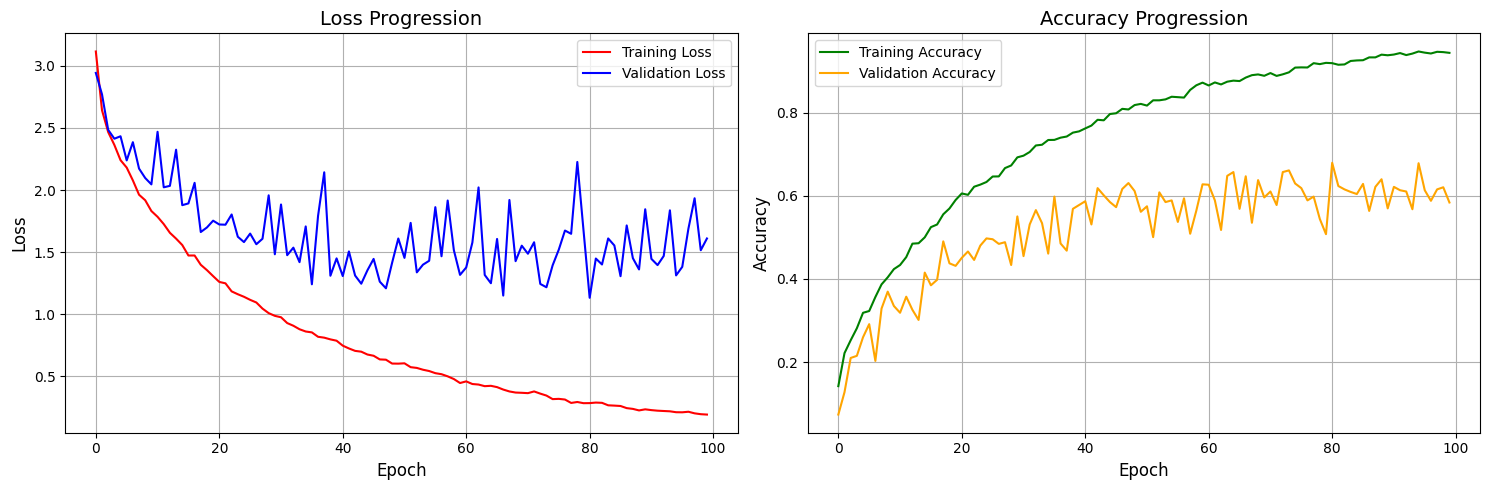

In [207]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    start_from_epoch=90
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

# best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))+1
# print('best_epoch: ', best_epoch)
visualize(history)

In [208]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9644 - loss: 0.1389 - weighted_accuracy: 0.9644
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6829 - loss: 1.2977 - weighted_accuracy: 0.6829


## **With Mel-Spectrogram, MFCCs, Chroma**

In [209]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc'], train_features['chroma']), axis=1)

print(training_features.shape)

(3954, 92, 259)


In [210]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc'], val_features['chroma']), axis=1)

print(validation_features.shape)

(985, 92, 259)


Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1072 - loss: 3.3180 - weighted_accuracy: 0.1072 - val_accuracy: 0.0832 - val_loss: 2.8865 - val_weighted_accuracy: 0.0832
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2043 - loss: 2.7255 - weighted_accuracy: 0.2043 - val_accuracy: 0.1452 - val_loss: 2.7200 - val_weighted_accuracy: 0.1452
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2533 - loss: 2.5167 - weighted_accuracy: 0.2533 - val_accuracy: 0.2396 - val_loss: 2.3761 - val_weighted_accuracy: 0.2396
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2965 - loss: 2.3256 - weighted_accuracy: 0.2965 - val_accuracy: 0.2934 - val_loss: 2.2659 - val_weighted_accuracy: 0.2934
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3036 - loss: 2.2523 - weighted_accuracy: 0.3036 - val_accuracy: 0.2934 - val_loss: 2.1851 - val_weighted_accuracy: 0.2934
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/s

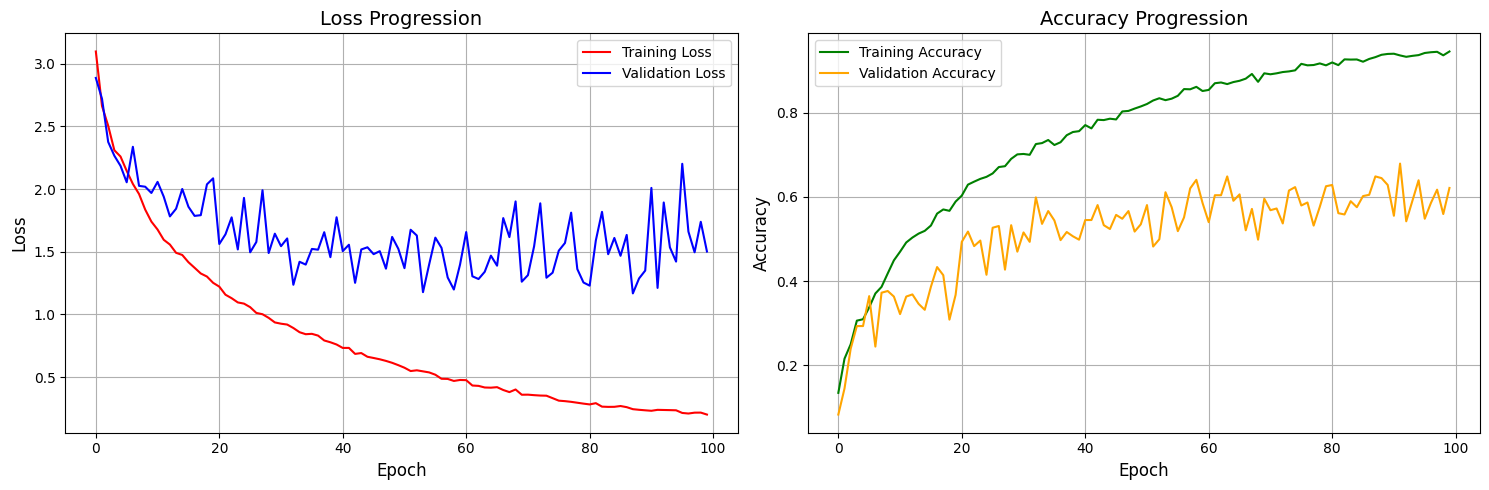

In [211]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    start_from_epoch=90
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

# best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))+1
# print('best_epoch: ', best_epoch)
visualize(history)

In [212]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9687 - loss: 0.1291 - weighted_accuracy: 0.9687
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6617 - loss: 1.2436 - weighted_accuracy: 0.6617


# Review results from all models

In [213]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.969,0.678
1,melspectrogram_chroma_mfcc,0.969,0.679
